# 2. Natural Language Processing

This notebook preprocesses and develops pipelines to classify posts from the two subreddits using classification models.

**Preprocessing and Modeling**
- Is text data successfully converted to a matrix representation?
- Are methods such as stop words, stemming, and lemmatization explored?
- Does the student properly split and/or sample the data for validation/training purposes?
- Does the student test and evaluate a variety of models to identify a production algorithm (**AT MINIMUM:** two classification models, **BONUS:** try a Naive Bayes)?
- Does the student defend their choice of production model relevant to the data at hand and the problem?
- Does the student explain how the model works and evaluate its performance successes/downfalls?

#### Imports

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import WordNetLemmatizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error, ConfusionMatrixDisplay, recall_score, precision_score, RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB

In [14]:
%store -r stop_words

In [15]:
df = pd.read_csv('../datasets/combined_cleaned.csv',na_filter=False)

#### Make train and test sets out of the train data

In [16]:
X = df['selftext']
y = df['subreddit']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,stratify=y)

In [18]:
y_test.value_counts()

Divorce            997
weddingplanning    987
Name: subreddit, dtype: int64

In [19]:
print(f'Baseline accuracy is {round(y_test.value_counts()[0]*100/len(y_test),1)}%.')

Baseline accuracy is 50.3%.


#### Encode subreddit

In [20]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [21]:
pd.DataFrame(y_test_enc).value_counts()

0    997
1    987
dtype: int64

Classes legend:
- 0: Divorce
- 1: WeddingPlanning

#### Create Lemmatizer

In [22]:
def lemma_tokenizer(doc):  ## Used class notes
    wnl = WordNetLemmatizer()
    return [w for w in word_tokenize(doc)]

### Pipelines

#### Logistic Regression Pipeline

In [23]:
df[df['selftext'].isna()]

,Unnamed: 0,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,...,preview,author_flair_background_color,banned_by,edited,call_to_action,category,num_posts,distinguished,posts_length,post_word_count


In [24]:
# First pass
pipe_lr = Pipeline([
    ('cv', CountVectorizer()),
    ('lr', LogisticRegression(max_iter = 10_000))
])
pipe_lr.fit(X_train, y_train)
pipe_lr.score(X_train, y_train), pipe_lr.score(X_test, y_test)

(0.939149436880148, 0.9112903225806451)

GridSearch

In [25]:
# params = {
#     'cv__tokenizer': [None,lemma_tokenizer]
# }

# gs_lr = GridSearchCV(
#     pipe_lr, param_grid=params,n_jobs=-1)

# gs_lr.fit(X_train,y_train_enc);

# gs_lr.best_params_

# gs_lr.best_score_

# gs_lr.cv_results_

I will feed this back into my model.

I will feed the results back into my model. Results:
- best_params = {'cv__min_df': 4, 'cv__ngram_range': (1, 3)} for params = {
    'cv__ngram_range':[(1,1),(1,2),(1,3),(1,4),(2,2),(2,3),(2,4)],
    'cv__min_df':np.arange(2,9)
}
- best_params = {'lr__C': 0.2} for params = {
    'lr__C': [1/20, 1/10, 1/5, 1/2, 1, 2, 5]
}
- no impact for params = {
    'cv__max_df': [0.4,0.5,0.6,0.7,0.8,0.9,1.0]
}
- best_params = {'cv__strip_accents': 'unicode'} (actually tie with None, but quicker) for params = {
    'cv__strip_accents': [None,'ascii', 'unicode']
}
- best_params = 'cv__tokenizer': None} for params = {
    'cv__tokenizer': [None,lemma_tokenizer]
}

In [26]:
# Best logistic model using gridsearch
pipe_lr = Pipeline([
    ('cv', CountVectorizer(stop_words=stop_words,ngram_range=(1,3),min_df=4,max_df=1.0,strip_accents='unicode')),
    ('lr', LogisticRegression(C=1/5))
])
pipe_lr.fit(X_train, y_train)
pipe_lr.score(X_train, y_train), pipe_lr.score(X_test, y_test)

(0.9324256177508825, 0.9143145161290323)

#### Decision Tree Pipeline

In [27]:
pipe_dt = Pipeline([
    ('cv', CountVectorizer(stop_words=stop_words,ngram_range=(1,2),min_df=4)),
    ('dt', DecisionTreeClassifier(max_depth=None,criterion='entropy',min_samples_split=3))
])
pipe_dt.fit(X_train, y_train)
pipe_dt.score(X_train, y_train), pipe_dt.score(X_test, y_test)

(0.9384770549672213, 0.8770161290322581)

In [28]:
# params_dt = {
#      'cv__max_df': [0.4,0.5,0.6,0.7,0.8,0.9,1.0] 
# }

# gs_dt = GridSearchCV(pipe_dt, param_grid = params_dt, n_jobs=-1)

# gs_dt.fit(X_train,y_train_enc);

# gs_dt.best_params_

# gs_dt.best_score_

# gs_dt.cv_results_

I will feed the results back into my model. Results:
- best_params = {'dt__criterion': 'entropy'} for params_dt = {
    'dt__criterion': ["gini", "entropy"]
}
- best_params = {'dt__criterion': 'entropy', 'dt__min_samples_split': 4} for params_dt = {
    'dt__criterion': ["gini", "entropy"],
    'dt__min_samples_split': [2,4,6],
}
- best_params = {'dt__criterion': 'entropy', 'dt__min_samples_split': 3} for params_dt = {
    'dt__criterion': ["entropy"],
    'dt__min_samples_split': [3,4,5],
}
- best_params = {'cv__min_df': 4, 'cv__ngram_range': (1, 2)} for params_dt = {
    'cv__ngram_range':[(1,1),(1,2),(1,3),(1,4),(2,2),(2,3),(2,4)], 'cv__min_df':np.arange(2,9) 
}
- best_params = {'cv__max_df': 0.5} for params_dt = {
     'cv__max_df': [0.4,0.5,0.6,0.7,0.8,0.9,1.0] 
}

In [29]:
# Best Model
pipe_dt = Pipeline([
    ('cv', CountVectorizer(stop_words=stop_words,ngram_range=(1,2),min_df=4,max_df=0.5)),
    ('dt', DecisionTreeClassifier(max_depth=None,criterion='entropy',min_samples_split=3))
])
pipe_dt.fit(X_train, y_train)
pipe_dt.score(X_train, y_train), pipe_dt.score(X_test, y_test)

(0.9384770549672213, 0.8775201612903226)

#### K Nearest Neighbors Pipeline

In [30]:
pipe_knn = Pipeline([
    ('cv', CountVectorizer(stop_words=stop_words,ngram_range=(1,3),min_df=4,max_df=1.0,strip_accents='unicode')),
    ('knn', KNeighborsClassifier(n_neighbors=5,p=2))
     ])
pipe_knn.fit(X_train, y_train)
pipe_knn.score(X_train, y_train), pipe_knn.score(X_test, y_test)

(0.7959320894267944, 0.688508064516129)

GridSearch

In [31]:
# params_knn = {
#     'cv__ngram_range':[(1,1),(1,2),(1,3),(1,4),(2,2),(2,3),(2,4)], 'cv__min_df':np.arange(2,9) 
# }

# gs_knn = GridSearchCV(
#     pipe_knn, param_grid=params_knn,n_jobs=-1)

# gs_knn.fit(X_train,y_train_enc);

# gs_knn.best_params_

# gs_knn.best_score_

# gs_knn.cv_results_

I will feed the results back into my model. Results:
- best_params = {'knn__n_neighbors': 5} for params_knn = {'knn__n_neighbors':np.arange(2,15)}
- best_params = {'knn__n_neighbors': 5, 'knn__p': 2} for params_knn = {
    'knn__n_neighbors':np.arange(3,7),
    'knn__p': [1,2]
}
- no impact for params_knn = {
     'cv__max_df': [0.4,0.5,0.6,0.7,0.8,0.9,1.0] 
}
- best_params = {'cv__min_df': 3, 'cv__ngram_range': (1, 1)} for params_knn = {
    'cv__ngram_range':[(1,1),(1,2),(1,3),(1,4),(2,2),(2,3),(2,4)], 'cv__min_df':np.arange(2,9) 
}

In [32]:
pipe_knn = Pipeline([
    ('cv', CountVectorizer(stop_words=stop_words,ngram_range=(1,1),min_df=3,max_df=1.0,strip_accents='unicode')),
    ('knn', KNeighborsClassifier(n_neighbors=5,p=2))
])
pipe_knn.fit(X_train, y_train)
pipe_knn.score(X_train, y_train), pipe_knn.score(X_test, y_test)

(0.7656749033451, 0.6854838709677419)

#### Random Forest Pipeline

In [33]:
pipe_rf = Pipeline([
    ('cv', CountVectorizer(stop_words=stop_words,ngram_range=(1,3),min_df=8,strip_accents = 'unicode')),
    ('rf', RandomForestClassifier(max_depth=None,n_estimators=500))
])
pipe_rf.fit(X_train, y_train)
pipe_rf.score(X_train, y_train), pipe_rf.score(X_test, y_test)

(0.9384770549672213, 0.9082661290322581)

In [34]:
# params_rf = {
#     'cv__min_df':np.arange(7,11)
# }

# gs_rf = GridSearchCV(pipe_rf, param_grid = params_rf, n_jobs=-1)

# gs_rf.fit(X_train,y_train_enc);

# gs_rf.best_params_

# gs_rf.best_score_

# gs_rf.cv_results_

I will feed the results back into my model. Results:
- best_params = {'cv__min_df': 8, 'cv__ngram_range': (1, 3)} for  'cv__ngram_range':[(1,1),(1,2),(1,3),(1,4),(2,2),(2,3),(2,4)], 'cv__min_df':np.arange(2,9)
- best_params = {'rf__max_depth': None, 'rf__n_estimators': 500} for params_rf = {
    'rf__max_depth':[None, 1,3,5],
    'rf__n_estimators':[100,500,700]
}
- best_params = {'cv__min_df': 7} for params_rf = {
    'cv__min_df':np.arange(7,11)
}

In [35]:
# Best model
pipe_rf = Pipeline([
    ('cv', CountVectorizer(stop_words=stop_words,ngram_range=(1,3),min_df=7,strip_accents = 'unicode')),
    ('rf', RandomForestClassifier(max_depth=None,n_estimators=500))
])
pipe_rf.fit(X_train, y_train)
pipe_rf.score(X_train, y_train), pipe_rf.score(X_test, y_test)

(0.9384770549672213, 0.9067540322580645)

#### Extra Trees Pipeline

In [36]:
pipe_et = Pipeline([
    ('cv', CountVectorizer(stop_words=stop_words,ngram_range=(1,3),min_df=3,strip_accents = 'unicode')),
    ('et', ExtraTreesClassifier())
])
pipe_et.fit(X_train, y_train)
pipe_et.score(X_train, y_train), pipe_et.score(X_test, y_test)

(0.9384770549672213, 0.9022177419354839)

In [37]:
pipe_et.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'cv', 'et', 'cv__analyzer', 'cv__binary', 'cv__decode_error', 'cv__dtype', 'cv__encoding', 'cv__input', 'cv__lowercase', 'cv__max_df', 'cv__max_features', 'cv__min_df', 'cv__ngram_range', 'cv__preprocessor', 'cv__stop_words', 'cv__strip_accents', 'cv__token_pattern', 'cv__tokenizer', 'cv__vocabulary', 'et__bootstrap', 'et__ccp_alpha', 'et__class_weight', 'et__criterion', 'et__max_depth', 'et__max_features', 'et__max_leaf_nodes', 'et__max_samples', 'et__min_impurity_decrease', 'et__min_samples_leaf', 'et__min_samples_split', 'et__min_weight_fraction_leaf', 'et__n_estimators', 'et__n_jobs', 'et__oob_score', 'et__random_state', 'et__verbose', 'et__warm_start'])

In [38]:
# params_et = {
#     'cv__ngram_range':[(1,1),(1,2),(1,3),(1,4),(2,2),(2,3),(2,4)],
#     'cv__min_df':np.arange(2,9)
# }

# gs_et = GridSearchCV(pipe_et, param_grid = params_et, n_jobs=-1)

# gs_et.fit(X_train,y_train_enc);

# gs_et.best_params_

# gs_et.best_score_

# gs_et.cv_results_

I will feed the results back into my model. Results:
- best_params = {'et__max_features': 'auto'} params_et = {
    'et__max_features':['auto', 'sqrt','log2']
}
- best_params = {'cv__min_df': 7, 'cv__ngram_range': (1, 4)} for params_et = {
    'cv__ngram_range':[(1,1),(1,2),(1,3),(1,4),(2,2),(2,3),(2,4)],
    'cv__min_df':np.arange(2,9)
}

In [39]:
# Best Model
pipe_et = Pipeline([
    ('cv', CountVectorizer(stop_words=stop_words,ngram_range=(1,4),min_df=7)),
    ('et', ExtraTreesClassifier())
])
pipe_et.fit(X_train, y_train)
pipe_et.score(X_train, y_train), pipe_et.score(X_test, y_test)

(0.9384770549672213, 0.9042338709677419)

#### Multinomial Naive Bayes Pipeline

In [40]:
pipe_mnb = Pipeline([
    ('cv', CountVectorizer(stop_words=stop_words,ngram_range=(1,3),min_df=3,strip_accents = 'unicode')),
    ('mnb', MultinomialNB())
])
pipe_mnb.fit(X_train, y_train)
pipe_mnb.score(X_train, y_train), pipe_mnb.score(X_test, y_test)

(0.8813245923684653, 0.8805443548387096)

In [41]:
# params_mnb = {
#     'mnb__alpha':[1/50,1/20,1/10]
# }

# gs_mnb = GridSearchCV(pipe_mnb, param_grid = params_mnb, n_jobs=-1)

# gs_mnb.fit(X_train,y_train_enc);

# gs_mnb.best_params_

# gs_mnb.best_score_

# gs_mnb.cv_results_

I will feed the results back into my model. Results:
- best_params = {'mnb__alpha': 0.1} for params_mnb = {
    'mnb__alpha':[1/10,1/2,1,2,5,10]
}
- best_params = {'mnb__alpha': 0.1} for params_mnb = {
    'mnb__alpha':[1/50,1/20,1/10]
}

In [42]:
# Best model
pipe_mnb = Pipeline([
    ('cv', CountVectorizer(stop_words=stop_words,ngram_range=(1,3),min_df=3,strip_accents = 'unicode')),
    ('mnb', MultinomialNB(alpha=1/10))
])
pipe_mnb.fit(X_train, y_train)
pipe_mnb.score(X_train, y_train), pipe_mnb.score(X_test, y_test)

(0.8838460245419398, 0.8810483870967742)

#### Compare confusion matrices

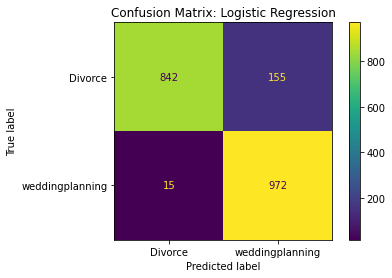

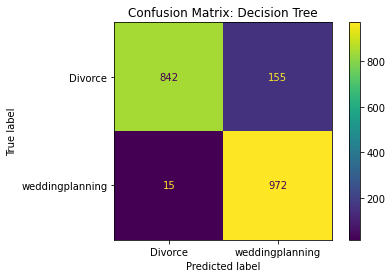

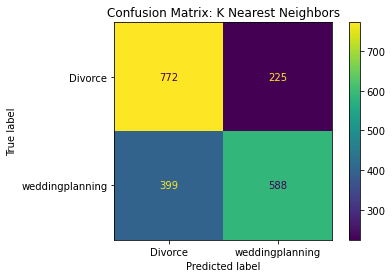

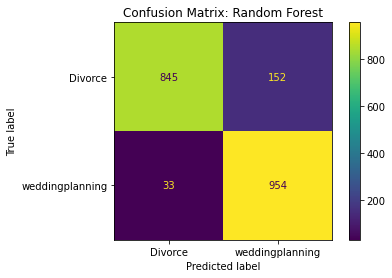

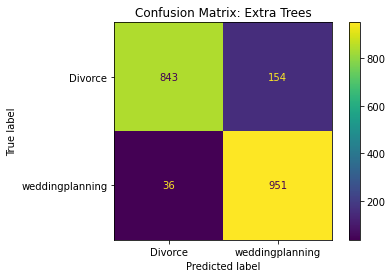

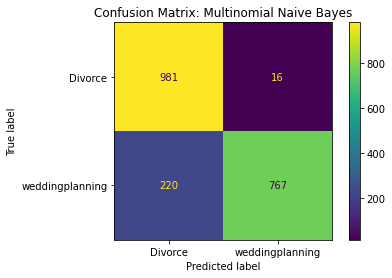

In [43]:
ConfusionMatrixDisplay.from_estimator(pipe_lr,X_test,y_test)
plt.title('Confusion Matrix: Logistic Regression');
ConfusionMatrixDisplay.from_estimator(pipe_lr,X_test,y_test)
plt.title('Confusion Matrix: Decision Tree');
ConfusionMatrixDisplay.from_estimator(pipe_knn,X_test,y_test)
plt.title('Confusion Matrix: K Nearest Neighbors');
ConfusionMatrixDisplay.from_estimator(pipe_rf,X_test,y_test)
plt.title('Confusion Matrix: Random Forest');
ConfusionMatrixDisplay.from_estimator(pipe_et,X_test,y_test)
plt.title('Confusion Matrix: Extra Trees');
ConfusionMatrixDisplay.from_estimator(pipe_mnb,X_test,y_test)
plt.title('Confusion Matrix: Multinomial Naive Bayes');

In [44]:
misclassifications

NameError: name 'misclassifications' is not defined

In [ ]:
misclassifications[misclassifications['true class'] != misclassifications['LR pred class']]

It seems that many of the classifications are being mispredicted because of the "removed" selftext. Let's see if we can add "Title" to make these predictions.